In [6]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [3]:
# 仮の観測データを生成（実際には観測されたデータを使用します）
np.random.seed(123)
true_mu = 0
true_sigma = 1
observed_data = np.random.normal(true_mu, true_sigma, 1000) #データを発生

with pm.Model() as model:
    # 事前分布を設定
    mu = pm.Normal('mu', mu=0, sigma=10)  # 平均の事前分布（適当な広い範囲を設定）
    sigma = pm.HalfNormal('sigma', sigma=10)  # 標準偏差の事前分布（正の値のみを取る）

    # 尤度（観測データに対するモデル）
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=observed_data)

    # MCMCを使ってサンプリング
    trace = pm.sample(3000, return_inferencedata=False) #arvizで事後予測分布を表示するために、return_inferencedata=Falseとしておく
    idata = pm.to_inference_data(trace)

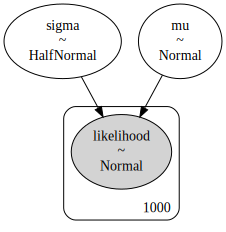

In [4]:
#モデルを可視化
pm.model_to_graphviz(model)

In [7]:
#1. az.summary(): 事後分布の要約 (事後分布の平均、標準偏差、MC誤差、信用区間（HDI: Highest Density Interval）などの要約統計量を表形式で表示します。これにより、パラメーター推定値の概要と不確実性を迅速に把握できます。)
az.summary(idata)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.039,0.031,-0.098,0.017,0.0,0.0,6400.0,3948.0,1.0
sigma,1.002,0.022,0.959,1.042,0.0,0.0,6673.0,4731.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

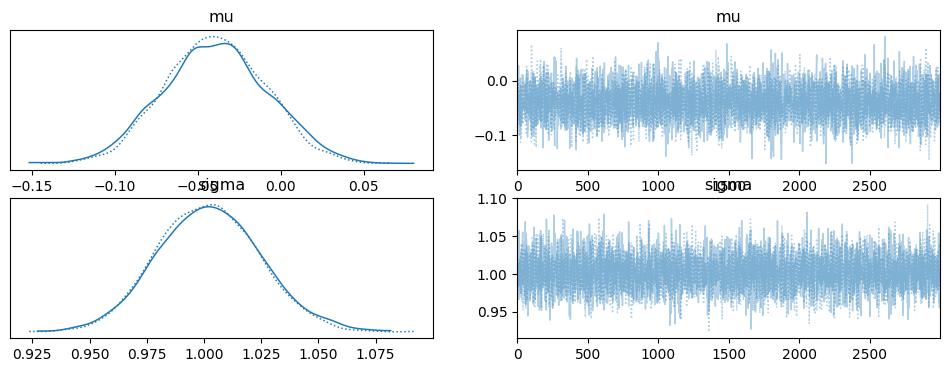

In [9]:
#2. 2. az.plot_trace(): トレースプロット (各パラメーターのサンプリングトレース（サンプルの系列）と事後分布のヒストグラムを表示します。このプロットは、サンプリングの収束状況や事後分布の形状を視覚的に評価するのに役立ちます。)
az.plot_trace(idata)

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

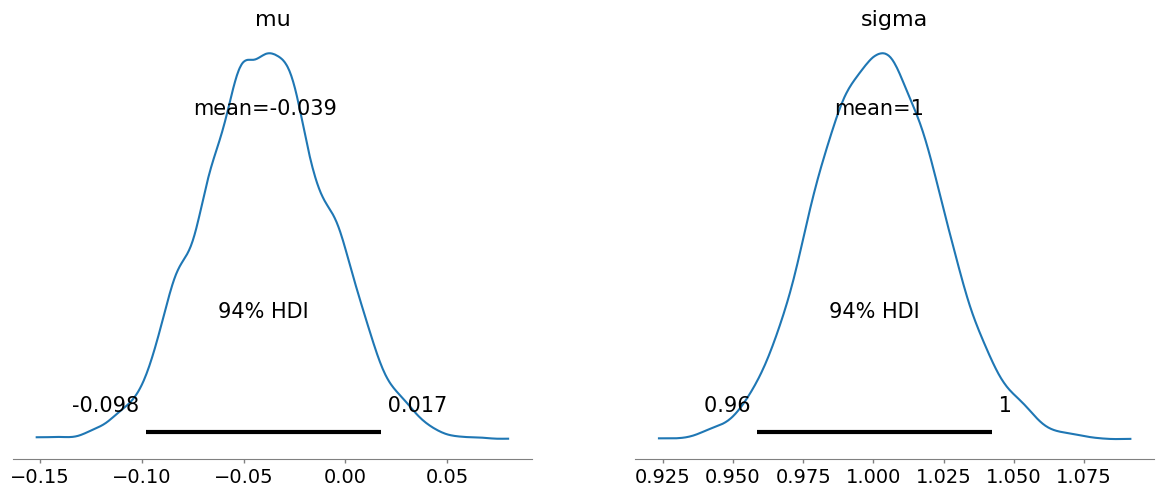

In [10]:
#3 3. az.plot_posterior(): 事後分布のプロット (パラメーターの事後分布をプロットし、平均や中央値、信用区間（HDI）を表示します。また、特定の閾値に基づいた事後確率の注釈を追加することもできます。)
az.plot_posterior(idata)

array([<Axes: title={'center': 'mu\n0'}>,
       <Axes: title={'center': 'mu\n1'}>,
       <Axes: title={'center': 'sigma\n0'}>,
       <Axes: title={'center': 'sigma\n1'}>], dtype=object)

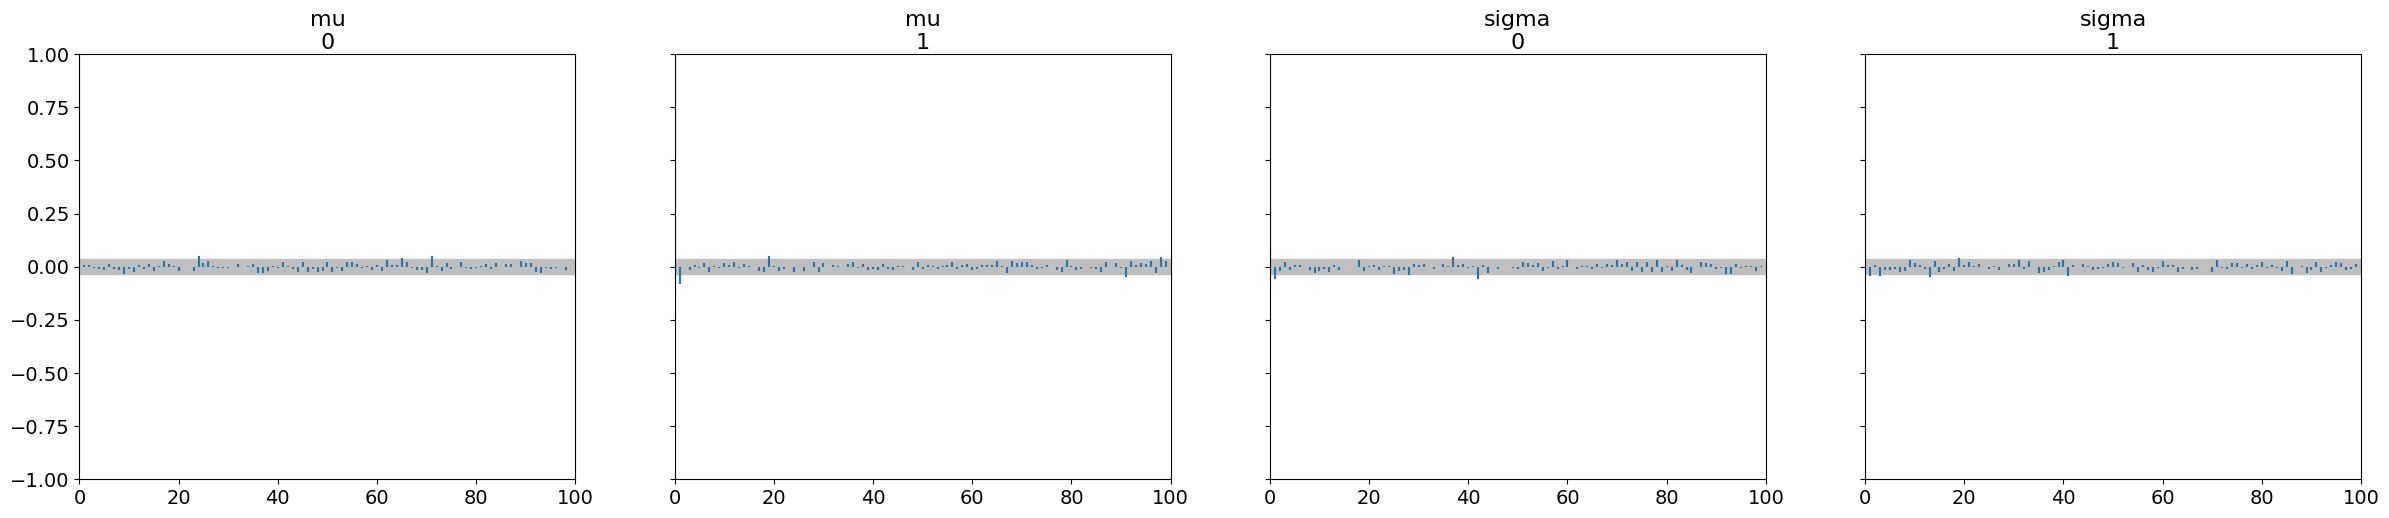

In [11]:
#4. az.plot_autocorr(): 自己相関のプロット (サンプリングされた系列の自己相関を表示します。自己相関が高い場合、サンプル間に相関があり、サンプリング効率が低いことを示します。これは、サンプルの薄間引き（thinning）を検討するか、サンプラーのパラメーターを調整する必要があることを示唆しています。)
az.plot_autocorr(idata)

<Axes: xlabel='mu', ylabel='sigma'>

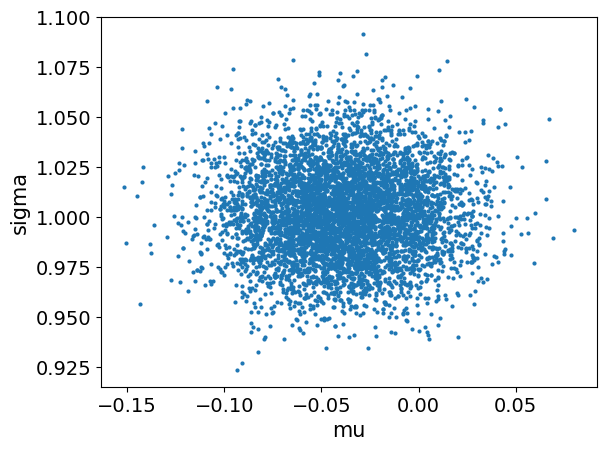

In [12]:
#5. az.plot_pair(): ペアプロット (複数のパラメーター間の関係性を散布図として可視化し、各パラメーターの事後分布も同時に表示します。パラメーター間の相関や事後分布の形状を把握するのに適しています。)
az.plot_pair(idata)

In [13]:
with model:
    # 事後予測サンプルを生成
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=False)
    idata_ppc = pm.to_inference_data(posterior_predictive=ppc)

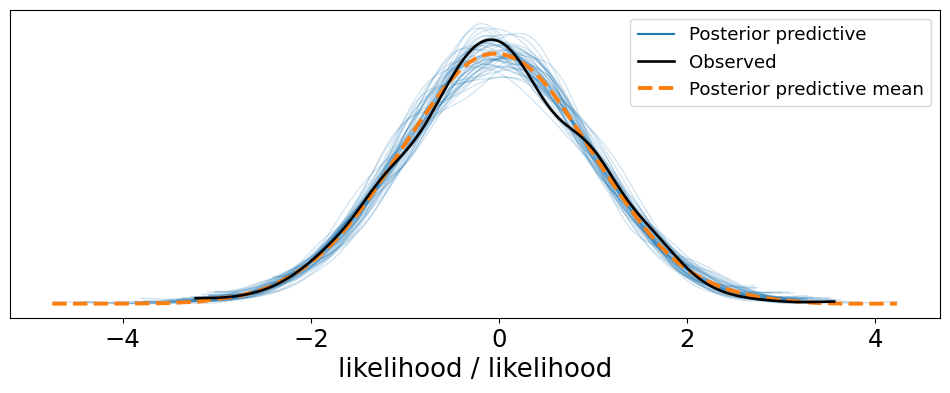

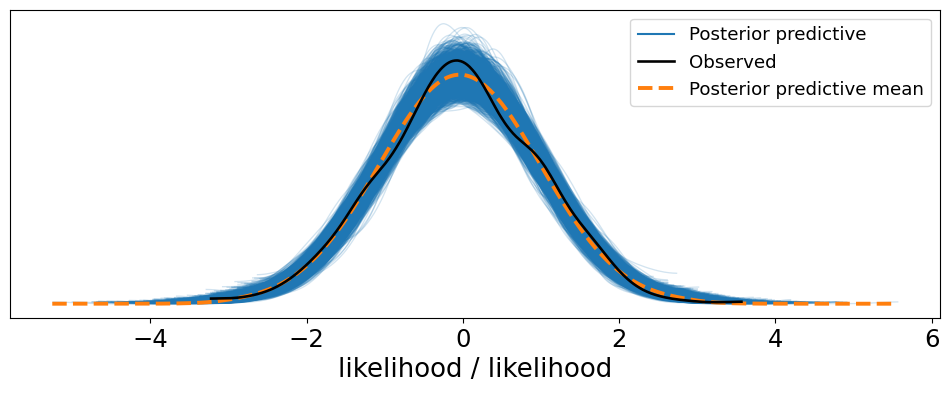

In [14]:
# 分布によるチェック
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));

In [16]:
shape = ppc['likelihood'].shape
print(f"チェーン数: {shape[0]}, サンプリング数: {shape[1]}, 観測値数: {shape[2]}")

チェーン数: 2, サンプリング数: 3000, 観測値数: 1000


In [17]:
# 事後予測分布から算出された辞書データ
posterior_predictive_sample = ppc

# 事後予測サンプリングの結果をフラット化
flattened_data = posterior_predictive_sample['likelihood'].reshape(-1, posterior_predictive_sample['likelihood'].shape[-1])

# データフレームを作成
# ここでは、各列が1つの観測値を表し、行がサンプリング番号（連結されたチェーンとサンプルインデックス）を表します
df = pd.DataFrame(flattened_data, columns=[f"Obs_{i+1}" for i in range(flattened_data.shape[1])])

# チェーンインデックスとサンプリングインデックスを行に追加
chain_lengths = posterior_predictive_sample['likelihood'].shape[1]
df['Chain_Index'] = np.repeat(np.arange(posterior_predictive_sample['likelihood'].shape[0]), chain_lengths)
df['Sample_Index'] = np.tile(np.arange(chain_lengths), posterior_predictive_sample['likelihood'].shape[0])

df

,Obs_1,Obs_2,Obs_3,Obs_4,Obs_5,Obs_6,Obs_7,Obs_8,Obs_9,Obs_10,...,Obs_993,Obs_994,Obs_995,Obs_996,Obs_997,Obs_998,Obs_999,Obs_1000,Chain_Index,Sample_Index
0,0.008651,2.238327,0.705627,1.230541,-0.130292,0.702450,0.379151,-0.914468,0.466001,0.185357,...,-0.236453,0.257196,0.498362,-1.130340,-0.762099,0.016549,-0.691311,-0.296906,0,0
1,0.481724,-0.724074,0.198710,-0.181864,0.862885,-0.981095,-0.810012,1.273896,0.418813,-0.542956,...,-1.224816,0.455151,0.984978,0.552951,0.769592,-0.054275,0.344595,-0.457713,0,1
2,-0.759501,-1.070825,-0.218223,-0.672295,0.381031,-0.401974,-0.807835,-1.080223,-0.272940,-0.053654,...,-1.334030,-0.313163,-0.664514,0.977638,-0.026188,0.378467,-0.902085,1.917408,0,2
3,1.363444,0.854138,0.862429,0.617021,1.983597,-0.520249,1.328943,0.752154,-0.678332,0.599262,...,-1.004752,0.863216,-0.799352,0.082709,-0.890937,0.901410,1.806968,-0.348348,0,3
4,0.424610,1.472439,-0.586149,-0.778489,-0.020444,1.615143,-0.496962,-0.448903,-0.287827,0.215911,...,0.698859,-0.291628,0.417073,0.391615,-0.524401,-0.771959,-0.282019,0.576071,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.367279,0.809842,1.722129,1.035687,-0.617338,-1.203951,0.161606,0.431063,-0.853256,0.181812,...,-1.604568,-0.200180,0.070928,0.757557,-0.560475,0.869553,-0.666519,-0.724977,1,2995
5996,3.025652,0.518696,-0.529414,0.924536,-2.489494,0.062728,0.871799,1.251119,1.000151,-0.098540,...,0.689510,-0.465831,-1.080007,-0.030242,0.688396,-0.095535,-0.355191,1.033550,1,2996
5997,0.729971,0.316633,-0.550861,-0.054914,-2.073057,1.641760,-0.040603,1.699467,0.319524,0.846696,...,0.762262,0.420669,-1.089141,-0.091189,-1.088434,-1.073975,1.869081,-0.927945,1,2997
5998,0.294678,0.274952,0.257511,1.260942,0.867898,1.418905,-1.578719,0.531989,-1.215074,-0.616318,...,0.039863,-0.171487,0.277358,-0.013961,0.427471,0.047803,-0.871113,-0.859402,1,2998
